In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import segmentation_models as sm
import functools as ft
import pandas as pd
import numpy as np
import tensorflow.keras as keras

sm.set_framework("tf.keras")
sm.framework()

tf.random.set_seed(1024)
SEED = 1024


Segmentation Models: using `keras` framework.


In [3]:
def get_image_decode(image, label):
    image = tf.io.read_file(image, "image")
    label = tf.io.read_file(label, "label")

    image = tf.image.decode_image(image)
    label = tf.image.decode_image(label)

    return image, label


# [w, h, c], 448, 448, 3
def decode_crop(image, label):
    image = image[368 // 2 : -(368 // 2), 256 // 2 : -(256 // 2)]
    label = label[368 // 2 : -(368 // 2), 256 // 2 : -(256 // 2)]

    img_array = []
    label_array = []

    for index in range(4 * 8):
        x, y = index // 8, index % 8
        img_array.append(image[448 * x : 448 * (1 + x), 448 * y : 448 * (1 + y)])
        label_array.append(label[448 * x : 448 * (1 + x), 448 * y : 448 * (1 + y)])

    return tf.data.Dataset.from_tensor_slices((img_array, label_array))


def get_mask(image, label):
    labels = []
    labels.append((label[:, :, 0] == 0) & (label[:, :, 1] == 0) & (label[:, :, 2] == 0))
    labels.append(
        (label[:, :, 0] == 128) & (label[:, :, 1] == 0) & (label[:, :, 2] == 0)
    )
    labels.append(
        (label[:, :, 0] == 128) & (label[:, :, 1] == 64) & (label[:, :, 2] == 128)
    )
    labels.append(
        (label[:, :, 0] == 0) & (label[:, :, 1] == 128) & (label[:, :, 2] == 0)
    )
    labels.append(
        (label[:, :, 0] == 128) & (label[:, :, 1] == 128) & (label[:, :, 2] == 0)
    )
    labels.append(
        (label[:, :, 0] == 64) & (label[:, :, 1] == 0) & (label[:, :, 2] == 128)
    )
    labels.append(
        (label[:, :, 0] == 192) & (label[:, :, 1] == 0) & (label[:, :, 2] == 192)
    )
    labels.append(
        (label[:, :, 0] == 64) & (label[:, :, 1] == 64) & (label[:, :, 2] == 0)
    )
    labels = tf.cast(labels, tf.float32)
    image = tf.cast(image, tf.float32)

    # must perform this
    return image, tf.transpose(labels, [1, 2, 0])


def create_ds(batch_size, istrain=True, maximage=False):
    AUTOTUNE = tf.data.AUTOTUNE

    if istrain:
        directory = (
            "C:/home/dataset/uavid_v1.5_official_release/uavid_train/**/Images/*.png"
        )
        images = glob.glob(directory, recursive=True)
        directory = (
            "C:/home/dataset/uavid_v1.5_official_release/uavid_train/**/Labels/*.png"
        )
        labels = glob.glob(directory, recursive=True)
    else:
        directory = (
            "C:/home/dataset/uavid_v1.5_official_release/uavid_val/**/Images/*.png"
        )
        images = glob.glob(directory, recursive=True)
        directory = (
            "C:/home/dataset/uavid_v1.5_official_release/uavid_val/**/Labels/*.png"
        )
        labels = glob.glob(directory, recursive=True)

    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    ds = ds.cache()
    if istrain:
        ds = ds.shuffle(6400, SEED, reshuffle_each_iteration=True)
    ds = ds.map(get_image_decode, AUTOTUNE)

    if not maximage:
        ds = ds.flat_map(decode_crop)

    ds = ds.map(get_mask, AUTOTUNE)

    # batch and prefetch
    ds = ds.batch(batch_size)

    if istrain:
        ds = ds.prefetch(AUTOTUNE)

    return ds

In [4]:
def create_backbone_efficient():
    _backbone = keras.applications.EfficientNetB0(include_top=False)

    outputs = [
        layer.output
        for layer in _backbone.layers
        if layer.name
        in [
            "block2a_activation",
            "block3a_activation",
            "block5a_activation",
            "block7a_activation",
        ]
    ]

    return tf.keras.Model(
        inputs=[_backbone.input], outputs=outputs, name="efficientb0_backbone"
    )


In [5]:
class FPN(tf.keras.layers.Layer):
    def __init__(self, backbone=None, **kwargs):
        super().__init__(name="Feature_Pyramid_Network", **kwargs)

        self.backbone = create_backbone_efficient()

        self.conv5_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv4_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv3_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv2_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv5_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv5_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv4_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv4_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv3_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv3_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv2_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv2_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.upscale = tf.keras.layers.UpSampling2D(size=(2, 2))

    def call(self, images, training=False):
        # 112x112, 56x56, 28x28, 14x14
        conv2, conv3, conv4, conv5 = self.backbone(images, training=False)
        conv5_m = self.conv5_1x1(conv5)
        conv5_p = self.conv5_3x3_1(conv5_m)
        conv5_p = self.conv5_3x3_2(conv5_p)

        conv4_m_1 = self.upscale(conv5_m)
        conv4_m_2 = self.conv4_1x1(conv4)
        conv4_m = conv4_m_1 + conv4_m_2
        conv4_p = self.conv4_3x3_1(conv4_m)
        conv4_p = self.conv4_3x3_2(conv4_p)

        conv3_m_1 = self.upscale(conv4_m)
        conv3_m_2 = self.conv3_1x1(conv3)
        conv3_m = conv3_m_1 + conv3_m_2
        conv3_p = self.conv3_3x3_1(conv3_m)
        conv3_p = self.conv3_3x3_2(conv3_p)

        conv2_m_1 = self.upscale(conv3_m)
        conv2_m_2 = self.conv2_1x1(conv2)
        conv2_m = conv2_m_1 + conv2_m_2
        conv2_p = self.conv2_3x3_1(conv2_m)
        conv2_p = self.conv2_3x3_2(conv2_p)

        return conv5_p, conv4_p, conv3_p, conv2_p


class FCN(tf.keras.Model):
    def __init__(self, n_classes=8, backbone=None, **kwargs):
        super().__init__(name="FCN", **kwargs)
        self.fpn = FPN(backbone)
        self.upscale_2x = tf.keras.layers.UpSampling2D()
        self.upscale_4x = tf.keras.layers.UpSampling2D((4, 4))
        self.upscale_8x = tf.keras.layers.UpSampling2D((8, 8))
        self.concat = tf.keras.layers.Concatenate()
        self.conv6 = tf.keras.layers.Conv2D(
            filters=(512), kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv7 = tf.keras.layers.Conv2D(
            filters=n_classes, kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.upscale_final = tf.keras.layers.UpSampling2D(
            size=(4, 4), interpolation="bilinear"
        )

    def call(self, images, training=False):
        conv5_p, conv4_p, conv3_p, conv2_p = self.fpn(images, training=training)
        m_5 = self.upscale_8x(conv5_p)
        m_4 = self.upscale_4x(conv4_p)
        m_3 = self.upscale_2x(conv3_p)
        m_2 = conv2_p

        m_all = self.concat([m_2, m_3, m_4, m_5])
        m_all = self.conv6(m_all)
        m_all = self.conv7(m_all)
        m_all = self.upscale_final(m_all)

        return m_all


In [6]:
class FCN_ORIG(tf.keras.Model):
    def __init__(self, n_classes=8, backbone=None, **kwargs):
        super().__init__(name="FCN_ORIG", **kwargs)

        self.backbone = create_backbone_efficient()
        self.conv1 = tf.keras.layers.Conv2D(
            filters=(n_classes), kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv2D(
            filters=(n_classes), kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv2D(
            filters=(n_classes), kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.upscale2x_1 = tf.keras.layers.Convolution2DTranspose(
            filters=8,
            kernel_size=(4, 4),
            strides=(2, 2),
            padding="same",
            activation="relu",
        )
        self.upscale2x_2 = tf.keras.layers.Convolution2DTranspose(
            filters=8,
            kernel_size=(4, 4),
            strides=(2, 2),
            padding="same",
            activation="relu",
        )
        self.upscale2x_3 = tf.keras.layers.Convolution2DTranspose(
            filters=8,
            kernel_size=(4, 4),
            strides=(2, 2),
            padding="same",
            activation="relu",
        )
        self.upscale2x_4 = tf.keras.layers.Convolution2DTranspose(
            filters=8,
            kernel_size=(4, 4),
            strides=(4, 4),
            padding="same",
            activation="relu",
        )

    def call(self, images, training=False):
        conv1_o, conv2_o, conv3_o, conv4_o = self.backbone(images, training=False)
        conv1_o = self.conv1(conv1_o)
        conv2_o = self.conv2(conv2_o)
        conv3_o = self.conv3(conv3_o)

        fcn_16x = self.upscale2x_1(conv4_o) + conv3_o
        fcn_8x = self.upscale2x_2(fcn_16x) + conv2_o
        fcn_4x = self.upscale2x_3(fcn_8x) + conv1_o
        final_output = self.upscale2x_4(fcn_4x)
        return final_output


In [7]:
class RescalingUnet(keras.layers.Layer):
    def __init__(self):
        super(RescalingUnet, self).__init__()
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]

    def call(self, inputs):
        return ((inputs * (1 / 255.0)) - self.mean) / self.std


In [8]:
def load_model(model, path_name):
    """
    return None if no weight loaded
    """
    optimizer = tf.keras.optimizers.Adam()
    ckpt = tf.train.Checkpoint(model=model, optimizer=optimizer)
    ckptmg = tf.train.CheckpointManager(ckpt, path_name, 5)

    if ckptmg.latest_checkpoint is None:
        return None
    ckpt.restore(ckptmg.latest_checkpoint).expect_partial()
    return True


In [24]:
def combined_model_unetfpn(mode="multiply", n_classes=8):
    model_unet = sm.Unet(
        backbone_name="efficientnetb0",
        encoder_weights="imagenet",
        encoder_freeze=False,
        classes=n_classes,
        decoder_use_batchnorm=False,
    )
    model_fpn = FCN(n_classes)

    conv1x1 = keras.layers.Conv2D(n_classes, 1, padding="same", activation="softmax")
    input_layer = keras.layers.Input([None, None, 3])
    rescale_layer = RescalingUnet()

    if mode == "concat":
        concat = keras.layers.Concatenate()

    output_model_fcn = model_unet(rescale_layer(input_layer))
    output_model_fpn = model_fpn(input_layer)

    if mode == "multiply":
        output = output_model_fcn * output_model_fpn
    elif mode == "sum":
        output = output_model_fcn + output_model_fpn
    elif mode == "concat":
        output = concat([output_model_fcn, output_model_fpn])
    else:
        raise AssertionError("mode selected is not in the list")

    output_final = conv1x1(output)

    return keras.Model([input_layer], [output_final])


In [10]:
def combined_model_fcnfpn(mode="multi", n_classes=8):
    model_fcn = FCN_ORIG(n_classes)
    model_fpn = FCN(n_classes)

    conv1x1 = keras.layers.Conv2D(n_classes, 1, padding="same", activation="softmax")

    input_layer = keras.layers.Input([None, None, 3])
    output_model_fcn = model_fcn(input_layer)
    output_model_fpn = model_fpn(input_layer)
    output = output_model_fcn * output_model_fpn
    output_final = conv1x1(output)

    return keras.Model([input_layer], [output_final])


In [11]:
# the network must OUTPUT in logits [-inf, inf]
# make sure input dimension is [B, H, W, C]
def Jindex(target, pred, showPerChannel=False):
    intersection = tf.reduce_sum(target * pred, [0, 1, 2])
    union = tf.reduce_sum(target + pred, [0, 1, 2]) - intersection
    if showPerChannel:
        return (intersection + 0.1) / (union + 0.1)
    return tf.reduce_mean((intersection + 0.1) / (union + 0.1))

def Dice(target, pred):
    intersection = tf.reduce_sum(2 * pred * target, [0, 1, 2])
    union = tf.reduce_sum(pred + target, [0, 1, 2])
    return tf.reduce_mean((intersection + 0.1) / (union + 0.1))

In [12]:
def eval_model(model, trainds, testds):
    # evaluate on training set
    iteration = 0
    iou = tf.zeros([8])
    for bs_images, bs_label in trainds:
        output = model(bs_images, training=False)
        iou += Jindex(bs_label, output, showPerChannel=True)
        iteration += 1
    train_iou = iou / iteration

    # evaluate on test set
    iteration = 0
    iou = tf.zeros([8])
    for bs_images, bs_label in testds:
        output = model(bs_images, training=False)
        iou += Jindex(bs_label, output, showPerChannel=True)
        iteration += 1
    test_iou = iou / iteration

    print(f'Train IoU: {train_iou} | Train IoU: {test_iou}')

    return train_iou, test_iou

# Testing starts below

In [13]:
n_classes = 8
batch_size = 8
trainds = create_ds(batch_size)
testds = create_ds(batch_size, False)
iou_list = []

In [14]:
####################################
# UNET(MULTIPLY) + FPN
####################################
name = 'unetfpn'
model = combined_model_unetfpn()
optimizer = keras.optimizers.Adam(1e-5)

ckpt = tf.train.Checkpoint(model=model, optimizer=optimizer)
ckptmg = tf.train.CheckpointManager(ckpt, f"trained_model/unetfpn", 5)
ckptmg.restore_or_initialize()

train_iou, test_iou = eval_model(model, trainds, testds)
iou_list.append([name, train_iou, test_iou])
keras.backend.clear_session()
del model
del optimizer

Train IoU: [0.61340326 0.7165323  0.7726584  0.73893046 0.5548677  0.53651553
 0.6100276  0.5728835 ] | Train IoU: [0.50062925 0.767937   0.66911155 0.6871729  0.46713093 0.4122262
 0.4954623  0.527391  ]


In [21]:
####################################
# UNET(SUM) + FPN
####################################
name = 'unetfpnsum'
model = combined_model_unetfpn(mode='sum')
optimizer = keras.optimizers.Adam(1e-5)

ckpt = tf.train.Checkpoint(model=model, optimizer=optimizer)
ckptmg = tf.train.CheckpointManager(ckpt, f"trained_model/unetfpnsum", 5)
ckptmg.restore_or_initialize()

train_iou, test_iou = eval_model(model, trainds, testds)
iou_list.append([name, train_iou, test_iou])
keras.backend.clear_session()
del model
del optimizer

Train IoU: [0.58599585 0.7003448  0.7624127  0.7428644  0.56487536 0.50113183
 0.26505998 0.5649475 ] | Train IoU: [0.48164952 0.75921196 0.6588162  0.6961368  0.47559786 0.35010183
 0.22150333 0.5377825 ]


In [25]:
####################################
# UNET(CONCAT) + FPN
####################################
name = 'unetfpnconcat'
model = combined_model_unetfpn('concat')
optimizer = keras.optimizers.Adam(1e-5)

ckpt = tf.train.Checkpoint(model=model, optimizer=optimizer)
ckptmg = tf.train.CheckpointManager(ckpt, f"trained_model/unetfpnconcat", 5)
ckptmg.restore_or_initialize()

train_iou, test_iou = eval_model(model, trainds, testds)
iou_list.append([name, train_iou, test_iou])
keras.backend.clear_session()
del model
del optimizer

Train IoU: [0.60909754 0.8334732  0.7591826  0.75525427 0.57726675 0.8124956
 0.46495548 0.33268148] | Train IoU: [0.5046606  0.78979474 0.65481925 0.7017105  0.50141823 0.74325436
 0.37979952 0.38259658]


In [26]:
#####################################
# FCN + FPN
#####################################
name = 'fcnfpn'
model = combined_model_fcnfpn()
optimizer = keras.optimizers.Adam(1e-5)

ckpt = tf.train.Checkpoint(model=model, optimizer=optimizer)
ckptmg = tf.train.CheckpointManager(ckpt, f"trained_model/fcnfpn", 5)
ckptmg.restore_or_initialize()

train_iou, test_iou = eval_model(model, trainds, testds)
iou_list.append([name, train_iou, test_iou])
keras.backend.clear_session()
del model
del optimizer

Train IoU: [0.00696613 0.6068657  0.6888771  0.5654898  0.605201   0.3965852
 0.42334586 0.27038136] | Train IoU: [0.00297719 0.68747145 0.6080276  0.52946377 0.4952029  0.29093608
 0.34873298 0.1926941 ]


In [98]:
np.concatenate([['alan'], iou_list[0][1].numpy(),iou_list[0][1].numpy()])

array(['alan', '0.61340326', '0.7165323', '0.7726584', '0.73893046',
       '0.5548677', '0.53651553', '0.6100276', '0.5728835', '0.61340326',
       '0.7165323', '0.7726584', '0.73893046', '0.5548677', '0.53651553',
       '0.6100276', '0.5728835'], dtype='<U32')

In [137]:
def convert(x):
    return np.concatenate([[x[0]], x[1].numpy(), x[1].numpy()])

In [176]:
results = pd.DataFrame(
    list(map(convert, iou_list)),
    columns=[
        "model",
        "trainc1",
        "trainc2",
        "trainc3",
        "trainc4",
        "trainc5",
        "trainc6",
        "trainc7",
        "trainc8",
        "testc1",
        "testc2",
        "testc3",
        "testc4",
        "testc5",
        "testc6",
        "testc7",
        "testc8",
    ],
)
second = results.pop('model')

results.iloc[:, 0:] = results.iloc[:, 0:].astype('float')
results['model'] = second
results.dtypes

# results = results.astype(np.float32)

trainc1    float64
trainc2    float64
trainc3    float64
trainc4    float64
trainc5    float64
trainc6    float64
trainc7    float64
trainc8    float64
testc1     float64
testc2     float64
testc3     float64
testc4     float64
testc5     float64
testc6     float64
testc7     float64
testc8     float64
model       object
dtype: object

In [149]:
results.melt()

,variable,value
0,trainc1,0.613403
1,trainc1,0.585996
2,trainc1,0.609098
3,trainc1,0.006966
4,trainc2,0.716532
...,...,...
59,testc7,0.423346
60,testc8,0.572883
61,testc8,0.564947
62,testc8,0.332681


In [152]:
results.melt()

,variable,value
0,trainc1,0.613403
1,trainc1,0.585996
2,trainc1,0.609098
3,trainc1,0.006966
4,trainc2,0.716532
...,...,...
59,testc7,0.423346
60,testc8,0.572883
61,testc8,0.564947
62,testc8,0.332681


KeyError: 'model'

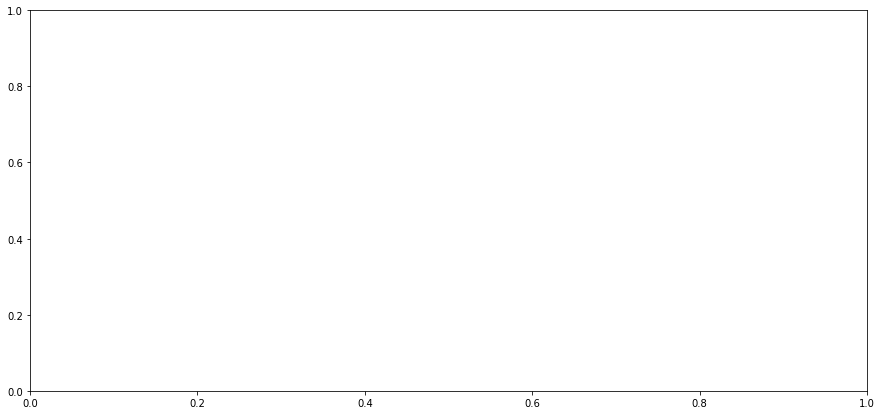

In [146]:
fg, ax = plt.subplots(figsize=(15, 7))
# sb.barplot(data=results.melt(id_vars='model').drop_duplicates(), y='value', x='variable', hue='model', ax=ax)
sb.barplot(ax=ax, data=results, '')
ax.set_xlabel('class')
ax.set_ylabel('IoU')